In [1]:
# %load_ext autoreload
# %autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
import importlib
import numpy as np
import torch
import time
import pickle

from pointcloud.configs import Configs
from pointcloud.utils.detector_map import get_projections, create_map
from pointcloud.data import dataset
from pointcloud.utils import gen_utils

from pointcloud.evaluation import generate, generate_for_metrics

import pointcloud.models.epicVAE_nflows_kDiffusion as mdls
import pointcloud.models.allCond_epicVAE_nflow_PointDiff as mdls2

cfg = Configs()

print(cfg.__dict__)

{'name': 'wish_', 'comet_project': 'wish', 'Acomment': 'test of data properties', 'log_comet': False, 'comet_workspace': 'none', 'model_name': 'wish', 'latent_dim': 0, 'beta_1': 0.0001, 'beta_T': 0.02, 'sched_mode': 'quardatic', 'flexibility': 0.0, 'truncate_std': 2.0, 'latent_flow_depth': 14, 'latent_flow_hidden_dim': 256, 'num_samples': 4, 'features': 4, 'sample_num_points': 2048, 'kl_weight': 0.001, 'residual': False, 'cond_features': 2, 'norm_cond': True, 'kld_min': 1.0, 'use_epic': False, 'epic_layers': 5, 'hidden_dim': 128, 'sum_scale': 0.001, 'weight_norm': True, 'flow_model': 'PiecewiseRationalQuadraticCouplingTransform', 'flow_transforms': 10, 'flow_layers': 2, 'flow_hidden_dims': 128, 'tails': 'linear', 'tail_bound': 10, 'storage_base': '/mnt/beegfs/desy/user/', 'dataset': 'x36_grid', 'dataset_path_in_storage': False, '_dataset_path': '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5', 'quantized_pos': False, 

# Shower Flow Model

In [3]:
flow, distribution = generate.load_flow_model(cfg, "../../../point-cloud-diffusion-logs/wish/from_rescaled_hls_v4.pt")

print('flow model loaded')

flow model loaded


# Diffusion Model

In [4]:
# from pointcloud.models.allCond_epicVAE_nflow_PointDiff import AllCond_epicVAE_nFlow_PointDiff
# from pointcloud.models.epicVAE_nflows_kDiffusion import epicVAE_nFlow_kDiffusion

# importlib.reload(mdls)
# importlib.reload(mdls2)


# cfg.sched_mode = 'quardatic'
# cfg.num_steps = 100
# cfg.residual = True
# cfg.latent_dim = 256
# model = mdls2.AllCond_epicVAE_nFlow_PointDiff(cfg).to(cfg.device)
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic
# model.load_state_dict(checkpoint['state_dict'])





# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_24__14_54_09/ckpt_0.000000_500000.pt')    # EDM BASELINE first training
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_31__17_57_11/ckpt_0.000000_1690000.pt')  # max 1760000

# cfg.model['sigma_data'] = 0.08
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_01__13_28_09/ckpt_0.000000_340000.pt')  # too wide cog_Y, too low hit_E

# RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_43_14/ckpt_0.000000_258000.pt')

# # RAdam optimizer, 2M iterations, scheduler from 300k-2M, EMApower 0.6667 - sigma_data=0.25
# cfg.model['sigma_data'] = 0.25
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__15_55_11/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=1e-4, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_40_41/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=True, lr=2e-3, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = True
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_36_04/ckpt_0.000000_920000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_03__10_24_31/ckpt_0.000000_737000.pt')

# # "sigma_data" : [0.08, 0.35, 0.08, 0.5]
# cfg.model['sigma_data'] = [0.08, 0.35, 0.08, 0.5]
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_27_15/ckpt_0.000000_300000.pt')

# # "sigma_data = 1
# cfg.model['sigma_data'] = 1.
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_28_38/ckpt_0.000000_280000.pt')

# # ""sigma_data = 0.1
# cfg.model['sigma_data'] = 0.1
# cfg.dropout_rate = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__13_34_50/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.05
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.05
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__14_21_41/ckpt_0.000000_320000.pt')

# # "sigma_data = 0.5, dropout=0.025
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.025
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_36_04/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.01
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.01
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_35_01/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=32
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__17_36_22/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=8
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 8
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__14_59_24/ckpt_0.000000_500000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=2
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 2
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__19_23_03/ckpt_0.000000_500000.pt')

# baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-5
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__14_54_11/ckpt_0.000000_410000.pt')

# # baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-6
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__16_12_53/ckpt_0.000000_410000.pt')

# # baseline with lat_dim = 256, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l1
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_26__14_42_09/ckpt_0.000000_500000.pt')  

# # baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l2
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_26__18_55_23/ckpt_0.000000_500000.pt')  

# # baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, dropout_mode=mid, dropout_rate=0.1
# cfg.dropout_mode = 'mid'
# cfg.dropout_rate = 0.1
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__13_58_28/ckpt_0.000000_325000.pt')   

# # baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, dropout_mode=mid, dropout_rate=0.05
# cfg.dropout_mode = 'mid'
# cfg.dropout_rate = 0.05
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__13_55_49/ckpt_0.000000_310000.pt')  

# baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, dropout_mode=mid, dropout_rate=0.025
# cfg.dropout_mode = 'mid'
# cfg.dropout_rate = 0.025
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__14_04_11/ckpt_0.000000_330000.pt')  

# # baseline with lat_dim = 0, max_iter 10M, lr=1e-3 fixed, dropout_rate=0.0, ema_power=2/3 (long training)   # DROPPED TO 1e-4 lr
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__23_09_03/ckpt_0.000000_3000000.pt')  

# # # baseline with lat_dim = 0, max_iter 10M, lr=1e-4 fixed, dropout_rate=0.0, ema_power=2/3 (long training)            USING THIS TRAINING
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__23_08_31/ckpt_0.000000_2000000.pt')    # max 5200000

# baseline with lat_dim = 32, max_iter 10M, lr=1e-3 FIXED, dropout_rate=0.0, ema_power=2/3 (long training)
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_07_02__20_28_57/ckpt_0.000000_2140000.pt')  

# baseline with lat_dim = 32, max_iter 10M, lr=1e-4 FIXED, dropout_rate=0.0, ema_power=2/3 (long training)
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_07_02__20_30_03/ckpt_0.000000_2170000.pt')  


# model = mdls.epicVAE_nFlow_kDiffusion(cfg).to(cfg.device)
# model.load_state_dict(checkpoint['others']['model_ema'])
# model.load_state_dict(checkpoint['state_dict'])

#  load model with torch load with name "model_ema


# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_570000.pt') #worst cog x
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_748000.pt') #best cog x

# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_sigmoid2023_04_06__16_35_47/ckpt_0.000000_849000.pt') # sigmoid 
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic



# CONSISTENCY MODESL

# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-3 fixed, num_steps=18, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_28_07/ckpt_0.000000_650000.pt') 
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256  sigma_max=80             GOOOOOD
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_30_39/ckpt_0.000000_1000000.pt')
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=40, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_31_45/ckpt_0.000000_695000.pt')
# long baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=10, epoch=1.69M, not EMA
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_07_02__21_08_51/ckpt_0.000000_1000000.pt')

# long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 0
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_07_07__16_32_09/ckpt_0.000000_1000000.pt')   # max 1200000


# model = mdls.epicVAE_nFlow_kDiffusion(cfg, distillation = True).to(cfg.device)
# model.load_state_dict(checkpoint['others']['model_ema'])
# model.load_state_dict(checkpoint['state_dict'])




# model.eval()

# print('model loaded')

In [5]:
caloclouds = "wish"
model, coef_real, coef_fake, n_splines = generate.load_diffusion_model(cfg, caloclouds, "../../../point-cloud-diffusion-logs/wish/from_rescaled_hls_v4.pt")

print(caloclouds, ' model loaded')

wish  model loaded


In [6]:
importlib.reload(gen_utils)

torch.manual_seed(1234567)

n_scaling = True

s_t = time.time()
fake_showers_3, fake_incident_3 = gen_utils.gen_showers_batch(model, distribution, 50, 50, 2000, bs=16, config=cfg, coef_real=coef_real, coef_fake=coef_fake, n_scaling=n_scaling)
t = time.time() - s_t
print(fake_showers_3.shape)
print(t)
print('time per shower: ', t / 2000)

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]

(2000, 60, 4)
92.70196890830994
time per shower:  0.04635098445415497


In [7]:
# sigmas = K.sampling.get_sigmas_karras(cfg.num_steps, cfg.sigma_min, cfg.sigma_max, rho=cfg.rho)
# print(sigmas)


In [8]:
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy', fake_showers)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_10-90GeV_40k.npy', fake_showers_2)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy', fake_showers_2)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_10-90GeV_40k.npy', fake_showers_3)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy', fake_showers_3)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_heun13_50GeV_2k.npy', fake_showers_3)  # seed 123

# for n hits calibration (n_scaling=False)
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k.npy', fake_showers_3)  # seed 1234  # new flow: 220714_cog_e_layer_ShowerFlow_best
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k.npy', fake_showers_3)  # seed 1234 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k.npy', fake_showers_3)  # seed 1234 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# final generation 
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling.npy', fake_showers_3)  # seed 12345  # new flow: 220714_cog_e_layer_ShowerFlow_best
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling.npy', fake_showers_3)  # seed 123456 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling.npy', fake_showers_3)  # seed 1234567 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# print('saved')

# Plots

In [9]:
title = r'\textbf{full spectrum}' #  r'\textbf{50 GeV}'
real_label = r'\textsc{Geant4}'
ddpm_label = r'\textsc{CaloClouds}'
edm_label = r'\textsc{CaloClouds II}'
cm_label = r'\textsc{CaloClouds II (CD)}'

In [10]:
from pointcloud.utils.detector_map import get_projections, create_map
import pointcloud.utils.plotting
importlib.reload(plotting)

import numpy as np
import matplotlib.pyplot as plt

In [11]:
cfg.dataset_path


'/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'

In [14]:
# path = "../../../point-cloud-diffusion-data/even_batch_10k.h5"
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/all_steps/validation/photon-showers_50GeV_A90_Zpos4.slcio.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/50GeV_x36_grid_regular_2k_Z4.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/10-90GeV_x36_grid_regular_float32.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/all_steps/validation/photon-showers_10-90GeV_A90_Zpos4.slcio.hdf5'
# path = '/beegfs/desy/user/akorol/projects/getting_high/ILDConfig/StandardConfig/production/out/10GeV_x36_grid_regular_2k_Z4_grid_pos_rundom.hdf5'
real_showers, real_energy = generate_for_metrics.get_g4_data(path)
dataset_class = dataset.dataset_class_from_config(Configs())
real_showers = real_showers[:]
real_showers[:, :, -1] = real_showers[:, :, -1] * dataset_class.energy_scale   # GeV to MeV
print(real_showers.shape)

# dequantization
# offset = 5.0883331298828125 / 6 # size of x36 granular grid
# pos_offset_x = np.random.uniform(0, offset, 1)
# pos_offset_z = np.random.uniform(0, offset, 1)
# offset = 5.0883331298828125 / 6 / 2  # size of x36 granular grid
# pos_offset_x = np.random.uniform(0, offset, len(real_showers)).reshape(-1,1)
# pos_offset_z = np.random.uniform(0, offset, len(real_showers)).reshape(-1,1)
# real_showers[:, 0, :] = real_showers[:, 0, :] + pos_offset_x
# real_showers[:, 2, :] = real_showers[:, 2, :] + pos_offset_z

# fake_showers = np.load('new_DM_50GeV_scaled_2.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

# fake_showers_2 = np.load('new_DM_50GeV_scaled.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('new_DM_50GeV_scaled_3.npy')
# fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000

# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_100s_30GeV_rearanged.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

# this method ensure axis order is [n_events, n_points, x_y_z_e]
fake_showers, _ = generate.load_np_showers('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy')
# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000  # MeV to GeV

# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy')
# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy')
fake_showers_2, _ = generate.load_np_showers('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_heun13_50GeV_2k.npy')
# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000   # MeV to GeV

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_50GeV_with_flow_corrections_best_cog.npy')
#fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_90GeV_with_flow_corrections_3.npy')
# fake_showers_3 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling.npy')
# fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000   # MeV to GeV

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_500s_10GeV_rearanged.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000


# fake_showers_worst = np.load('DM_10GeV_worst.npy')
# fake_showers_worst[:, -1] = fake_showers_worst[:, -1] / 1000

# fake_showers_worst_2 = np.load('DM_10GeV_worst_2.npy')
# fake_showers_worst_2[:, -1] = fake_showers_worst_2[:, -1] / 1000

(2000, 40000, 4)


In [15]:
real_showers[:2000,:,-1].max(), fake_showers_2[:2000,:,-1].max()

(9.530522, 38.28903579711914)

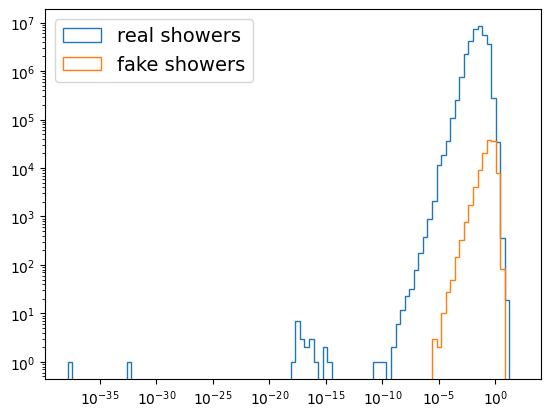

In [17]:
# log bins 
bins = np.logspace(np.log10(real_showers[:, :, -1][real_showers[:,:,-1] != 0.0].min()),np.log10(real_showers[:,:,-1].max()+1e2), 100)
plt.hist(real_showers[:,:,-1][real_showers[:,:,-1] != 0.0], bins = bins, histtype='step', label='real showers', density=False)
plt.hist(fake_showers_3[:,:,-1][fake_showers_3[:,:,-1] != 0.0], bins = bins, histtype='step', label='fake showers', density=False)   
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [18]:
# ### CoG shift correction for x and y coordinates
# fake_showers_3[:, 0] = fake_showers_3[:, 0] - (-0.10704701695531388) # calulated as cog_2[0].mean() - cog[0].mean() for 40k samples, E form 10 to 100 GeV
# fake_showers_3[:, 2] = fake_showers_3[:, 2] - (-0.3062229876492353) # calulated as cog_2[2].mean() - cog[2].mean() for 40k samples, E from 10 to 100 GeV

In [21]:
cfg_plt = plotting.PltConfigs()
cfg_plt.bins_cog = 50

In [29]:
cog_real = plotting.get_cog(real_showers)

cog = plotting.get_cog(fake_showers)

cog_2 = plotting.get_cog(fake_showers_2)

cog_3 = plotting.get_cog(fake_showers_3)

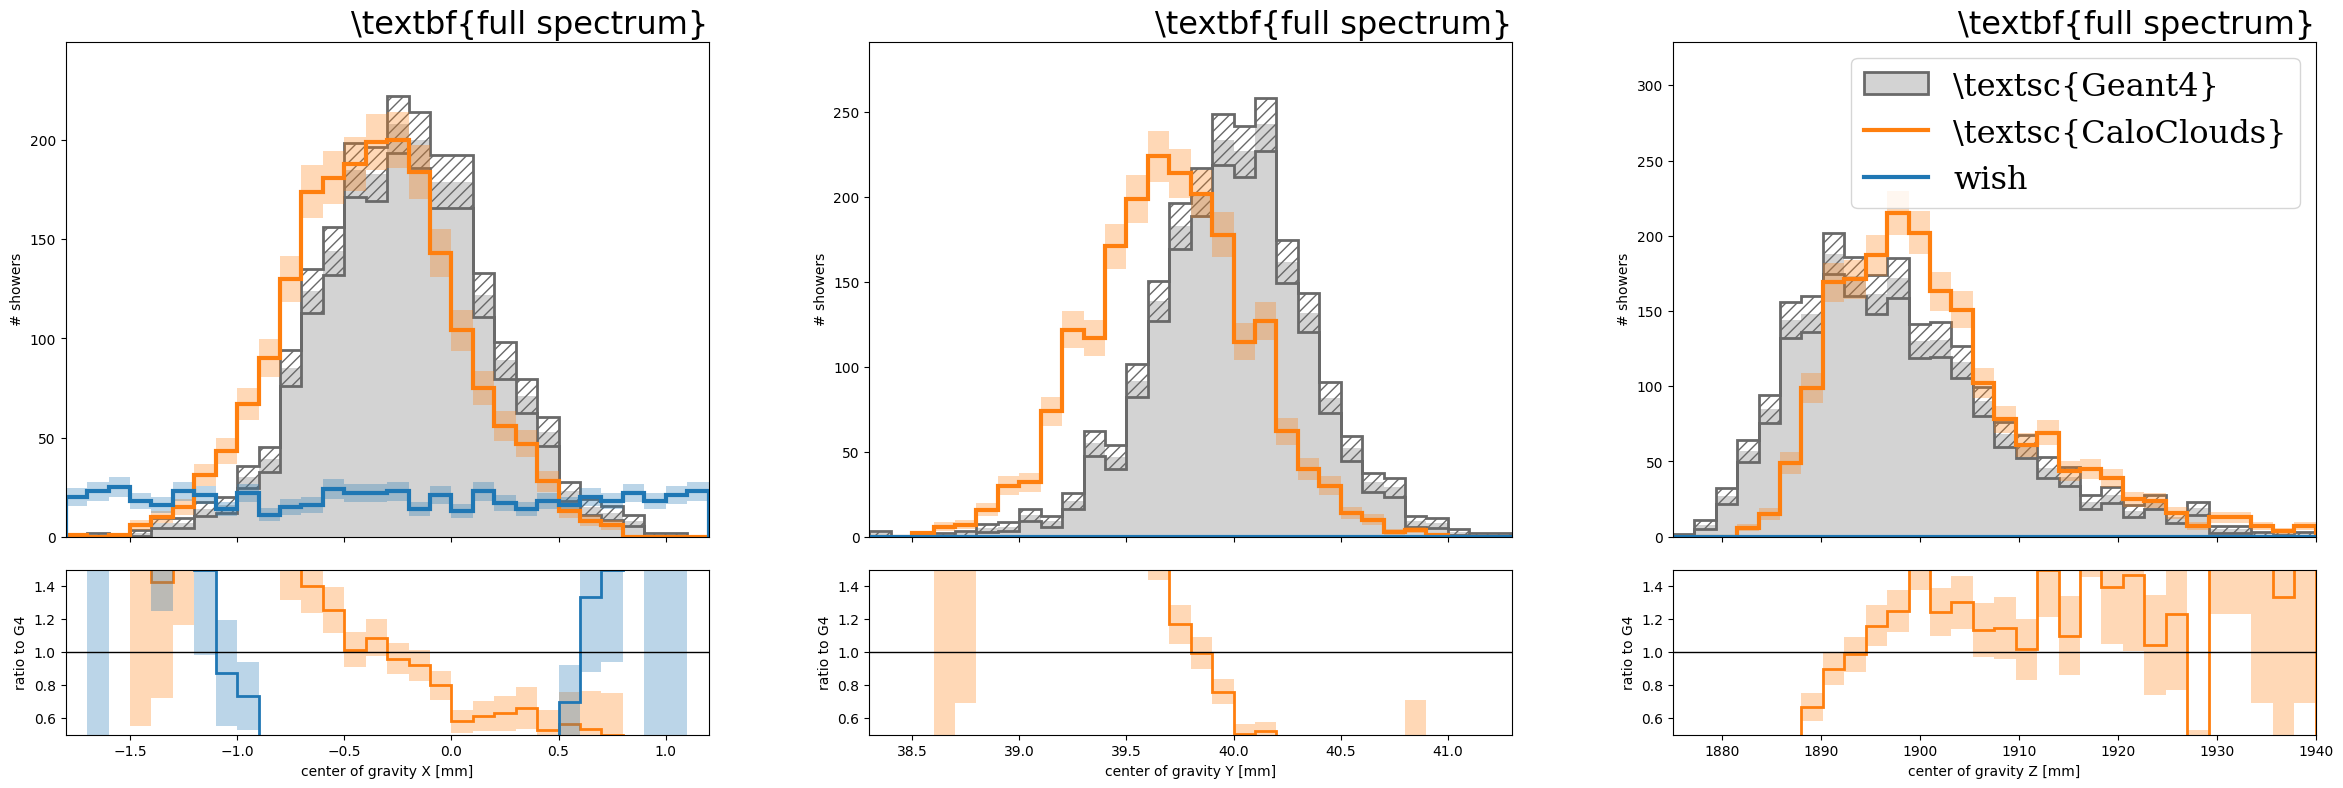

In [31]:
plotting.plt_cog(cog_real, [cog, cog_3], [real_label, ddpm_label, "wish"], title=title)

In [32]:
cog_real[2].mean(), cog[2].mean(), cog_2[2].mean(), cog_3[2].mean()

(39.988705, 39.70121926653574, 39.977212022101604, -0.10677484103493333)

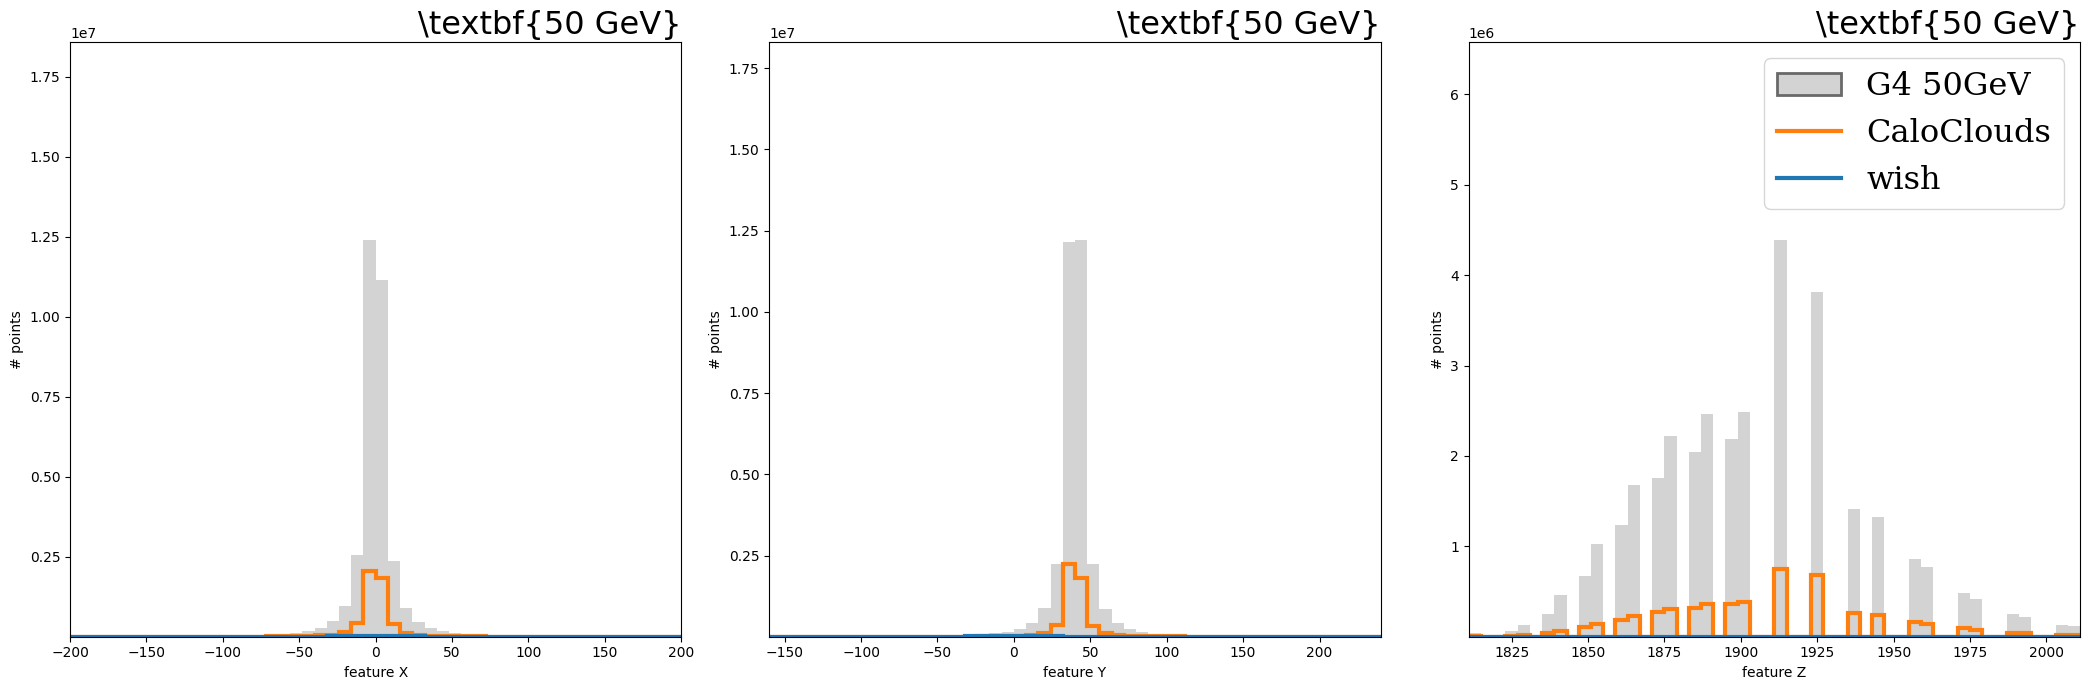

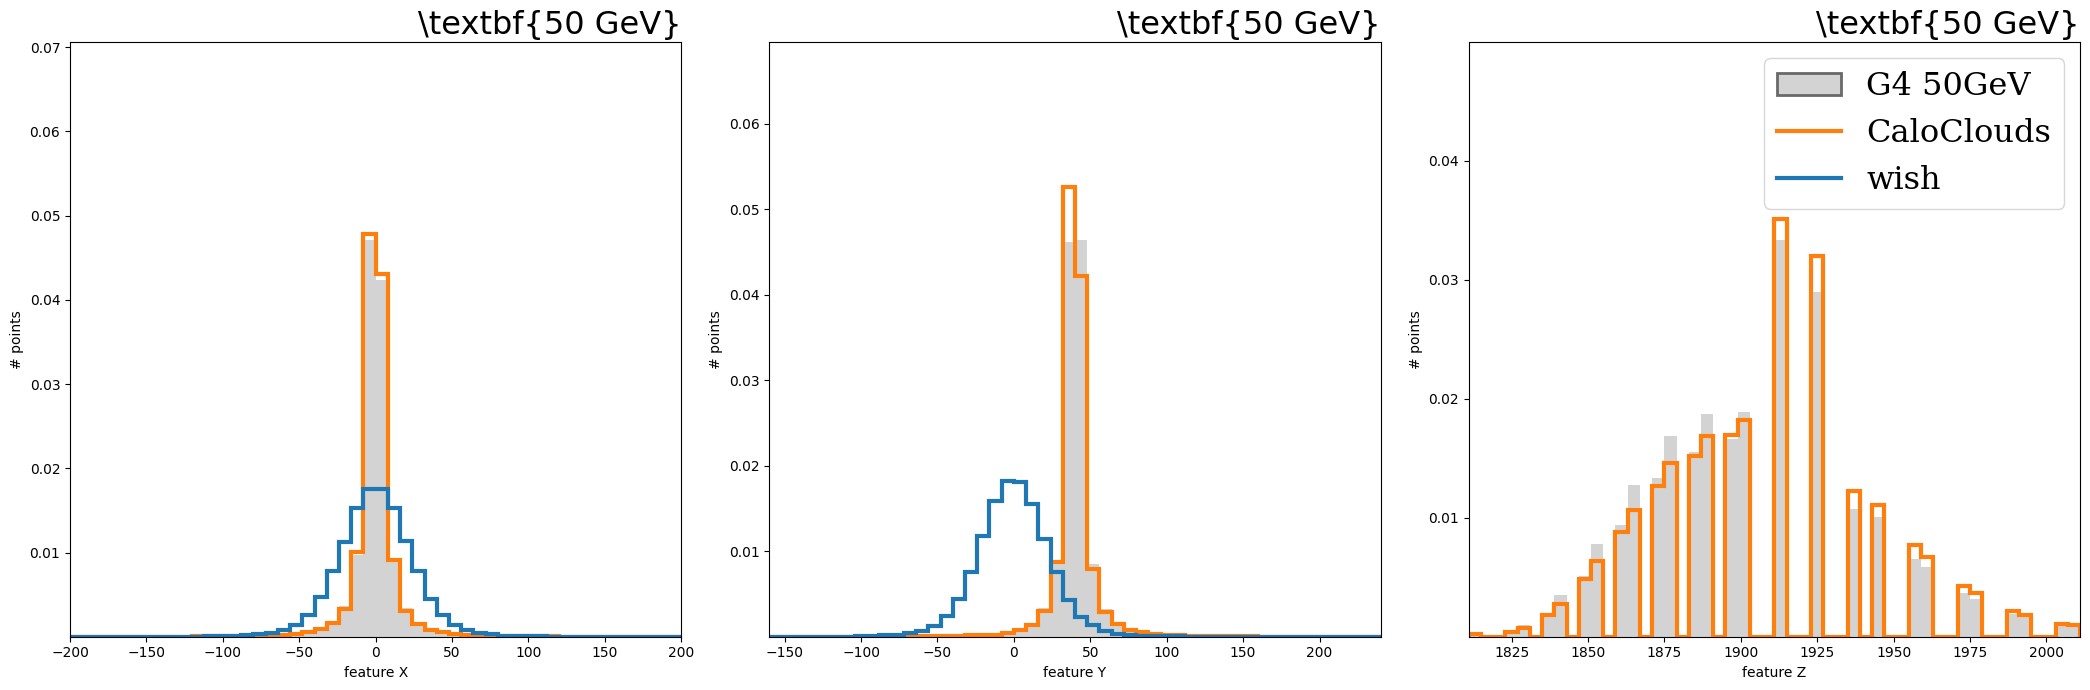

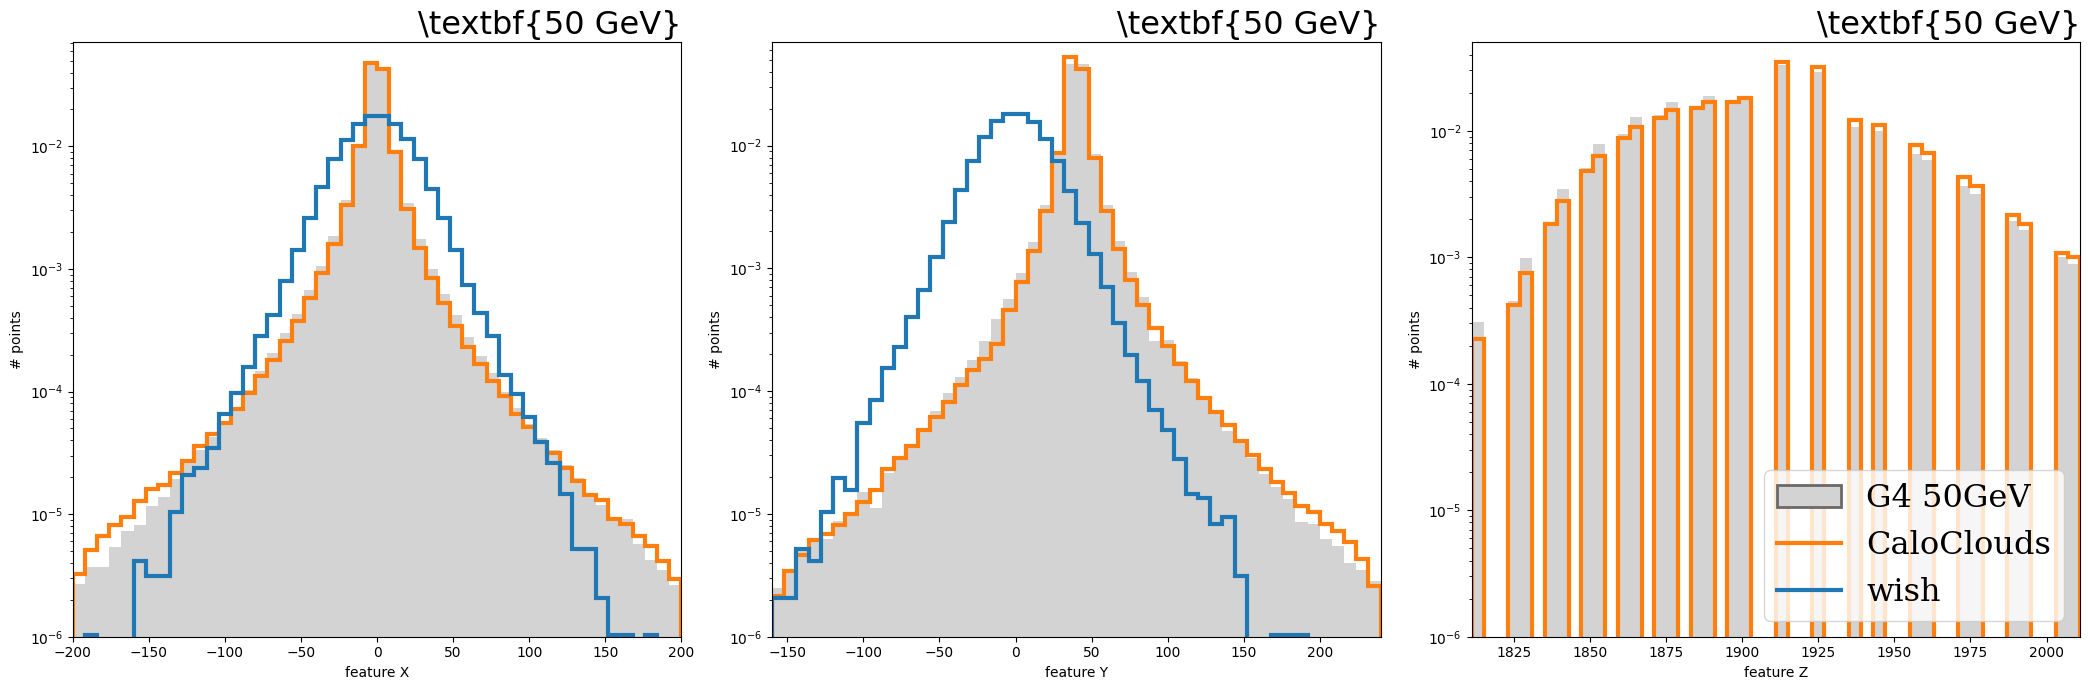

In [25]:
plotting.plt_feats(real_showers, [fake_showers, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'wish'], title=r'\textbf{50 GeV}', density=False)
plotting.plt_feats(real_showers, [fake_showers, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'wish'], title=r'\textbf{50 GeV}', density=True)
plotting.plt_feats(real_showers, [fake_showers, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'wish'], title=r'\textbf{50 GeV}', scale='log', density=True)

# Projections

In [47]:
MAP, _ = create_map(config=cfg)
events, cloud = get_projections(real_showers[0:2000], MAP, max_num_hits=6000, return_cell_point_cloud=True)
events_fake, cloud_fake = get_projections(fake_showers, MAP, max_num_hits=6000, return_cell_point_cloud=True)
events_fake_2, cloud_fake_2 = get_projections(fake_showers_2, MAP, max_num_hits=6000, return_cell_point_cloud=True)
events_fake_3, cloud_fake_3 = get_projections(fake_showers_3[0:2000], MAP, max_num_hits=6000, return_cell_point_cloud=True, config=cfg)

100%|██████████| 2000/2000 [00:07<00:00, 273.66it/s]


In [48]:
cloud[:,:,-1].max(), cloud_fake_3[:,:,-1].max()

(58.61740159720648, 0.0)

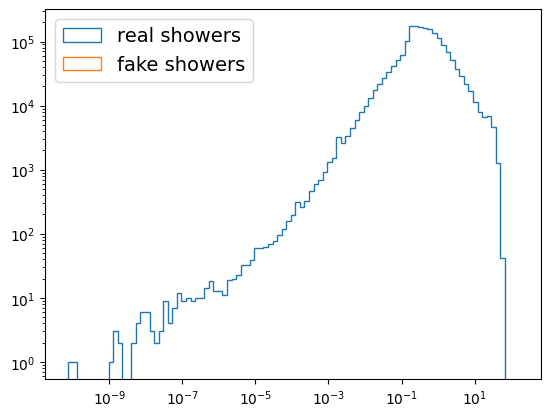

In [49]:
# log bins 
bins = np.logspace(np.log10(cloud[:,:,-1,][cloud[:,:,-1] != 0.0].min()),np.log10(cloud[:,:,-1].max()+1e2), 100)
plt.hist(cloud[:,:,-1][cloud[:,:,-1] != 0.0], bins = bins, histtype='step', label='real showers', density=False)
plt.hist(cloud_fake_3[:,:,-1][cloud_fake_3[:,:,-1] != 0.0], bins = bins, histtype='step', label='fake showers', density=False)   
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [50]:
for i in range(30):
    print(events[1000][i].max())
    

0.0
0.589491774328053
0.2897831639274955
0.2570129163505044
1.0837850347161293
2.6307610906660557
6.731190193037037
13.539332184183877
20.683528135899905
27.266637789958622
19.2256528820144
19.79462246168987
12.430063213207177
18.299942777688557
13.0625998651376
19.58751878765179
5.824597668630304
4.6115290021989495
6.895417167455889
9.385399739607237
12.484785945649492
23.533200661535375
9.699044685228728
19.61848322779406
11.761928891413845
11.591627355621313
6.099098558770493
8.541770109382924
1.220622068271041
1.201160654425621


In [51]:
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/real_10-90GeV_40k_projected.npy', events)

In [52]:
# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/real_10-90GeV_40k_projected.pickle', 'wb') as f: 
#     pickle.dump(events, f)

In [53]:
# # projected
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/real_10-90GeV_40k_projected.npy', events)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling_projected.npy', events_fake)  # seed 12345  # new flow: 220714_cog_e_layer_ShowerFlow_best
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling_projected.npy', events_fake_2)  # seed 123456 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling_projected.npy', events_fake_3)  # seed 1234567 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# # projected cloud
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/real_10-90GeV_40k_projected_cloud.npy', cloud)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling_projected_cloud.npy', cloud_fake)  # seed 12345  # new flow: 220714_cog_e_layer_ShowerFlow_best
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling_projected_cloud.npy', cloud_fake_2)  # seed 123456 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling_projected_cloud.npy', cloud_fake_3)  # seed 1234567 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# print('projected saved')


In [54]:
# # load 


# events = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/real_10-90GeV_40k_projected.npy')
# events_fake = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling_projected.npy')  # seed 12345  # new flow: 220714_cog_e_layer_ShowerFlow_best
# events_fake_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling_projected.npy')  # seed 123456 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# events_fake_3 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling_projected.npy')  # seed 1234567 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# cloud = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/real_10-90GeV_40k_projected_cloud.npy')
# cloud_fake = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling_projected_cloud.npy')  # seed 12345  # new flow: 220714_cog_e_layer_ShowerFlow_best
# cloud_fake_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling_projected_cloud.npy')  # seed 123456 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
# cloud_fake_3 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling_projected_cloud.npy')  # seed 1234567 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

# print('projected loaded')

In [55]:
mask = cloud[:,-1].sum(axis=1) == 0.0
print(mask.sum())

2000


In [56]:
importlib.reload(plotting)

n = 2000

c_cog = plotting.get_cog(cloud[:n])
print('1')

c_cog_2 = plotting.get_cog(cloud_fake[:n])
print('2')

c_cog_3 = plotting.get_cog(cloud_fake_2[:n])
print('3')


c_cog_4 = plotting.get_cog(cloud_fake_3[:n])
print('4')

c_cog_real = c_cog
c_cog_fake = [c_cog_2, c_cog_3, c_cog_4]


1
2
3
4


In [57]:
# pickle
# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/c_cog_real.pickle', 'wb') as f:
#     pickle.dump(c_cog_real, f)
# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/c_cog_fake.pickle', 'wb') as f:
#     pickle.dump(c_cog_fake, f)
# print('pickle saved')

# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/c_cog_real.pickle', 'rb') as f:
#     c_cog_real = pickle.load(f)
# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/c_cog_fake.pickle', 'rb') as f:
#     c_cog_fake = pickle.load(f)
# print('pickle loaded')

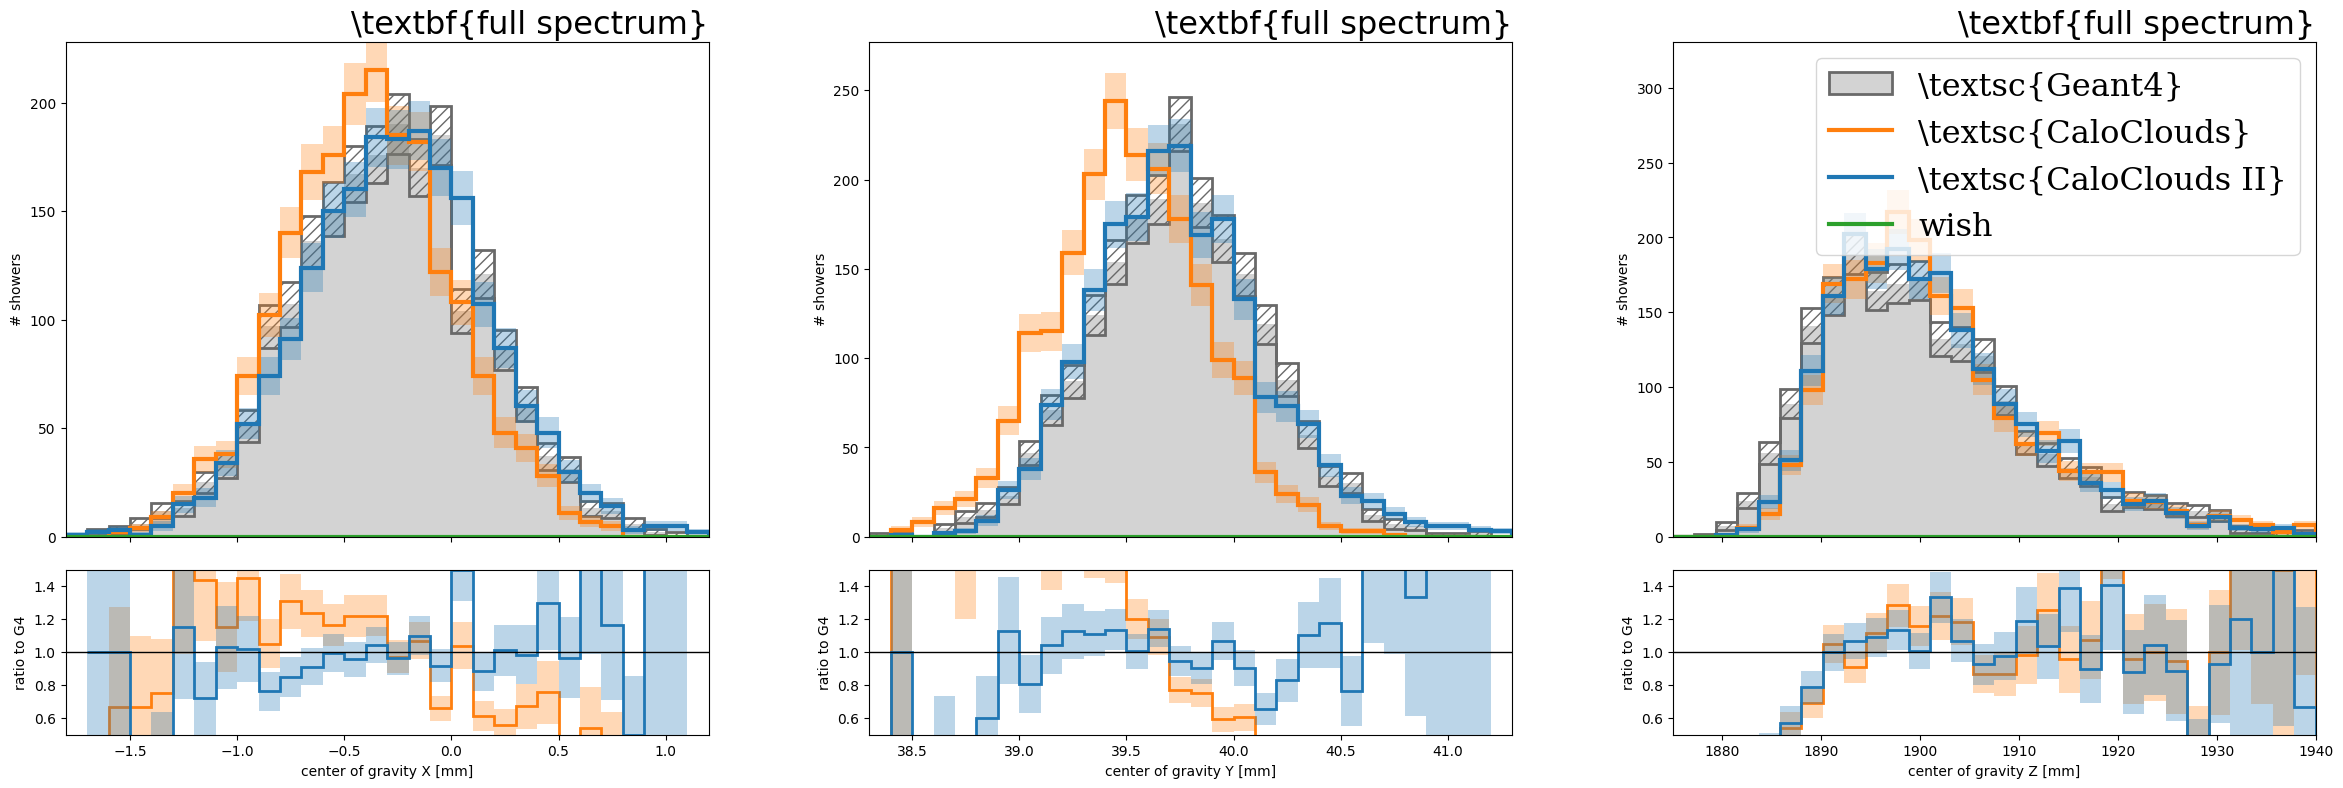

In [59]:
importlib.reload(plotting)
plotting.plt_cog(c_cog_real, c_cog_fake, [real_label, ddpm_label, edm_label, "wish"], title=title)

In [60]:
print(cog[0].mean(), cog_2[0].mean(), cog_3[0].mean(), cog_4[0].mean())
print(c_cog[0].mean(), c_cog_2[0].mean(), c_cog_3[0].mean(), c_cog_4[0].mean())

-0.3689550716086175 -0.24274506803954748 0.015094269934858162 0.015094269934858162
-0.29499950389601687 -0.3879653508926399 -0.24296926131517066 nan


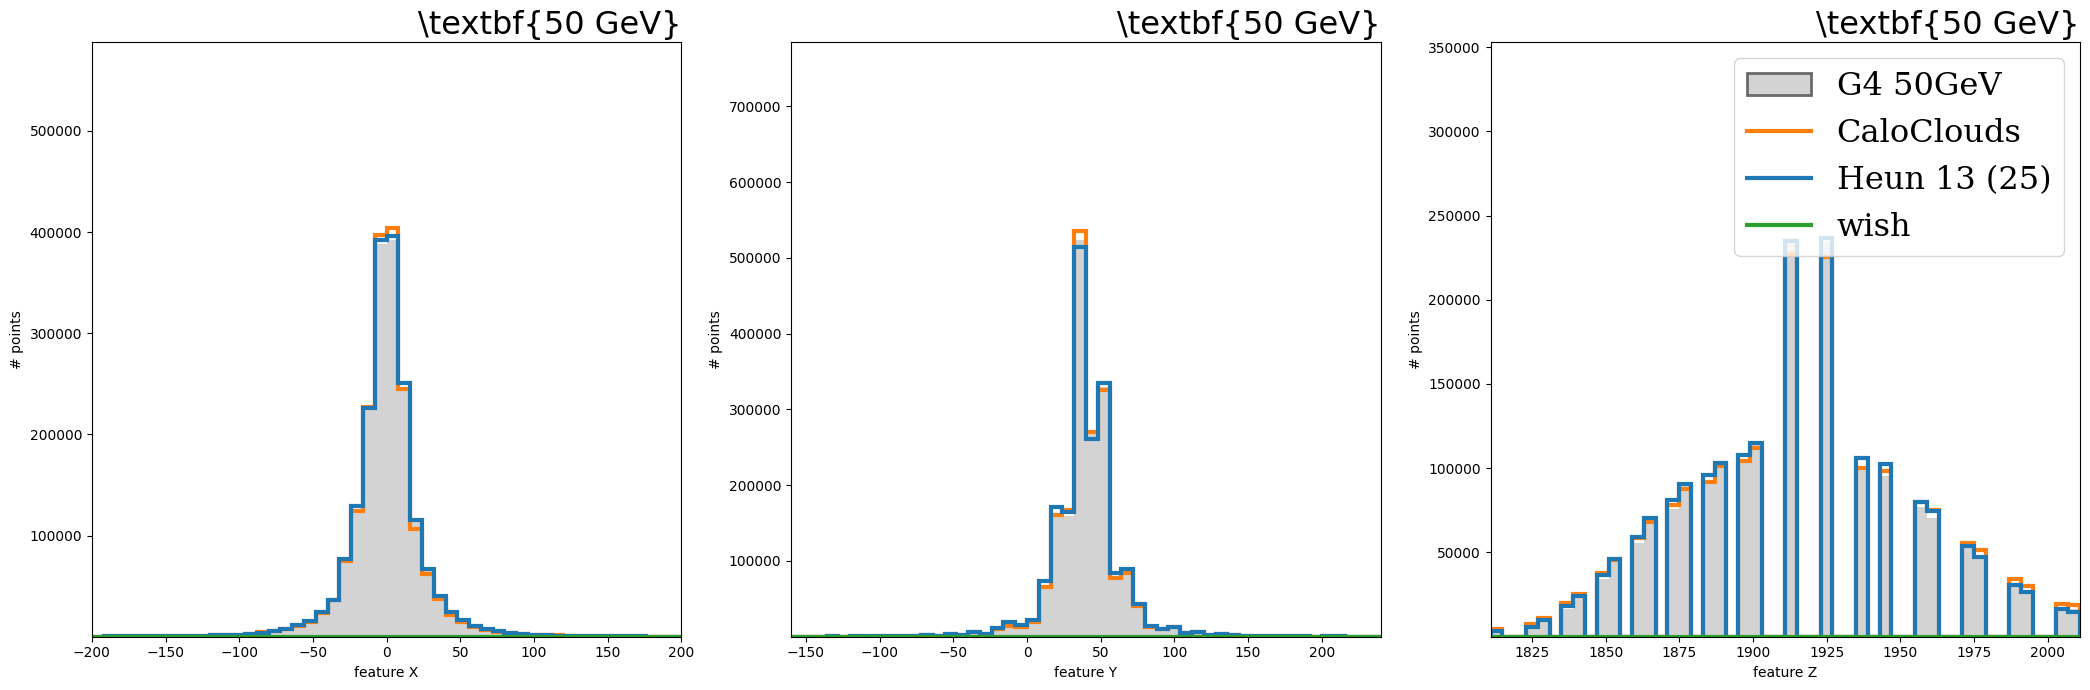

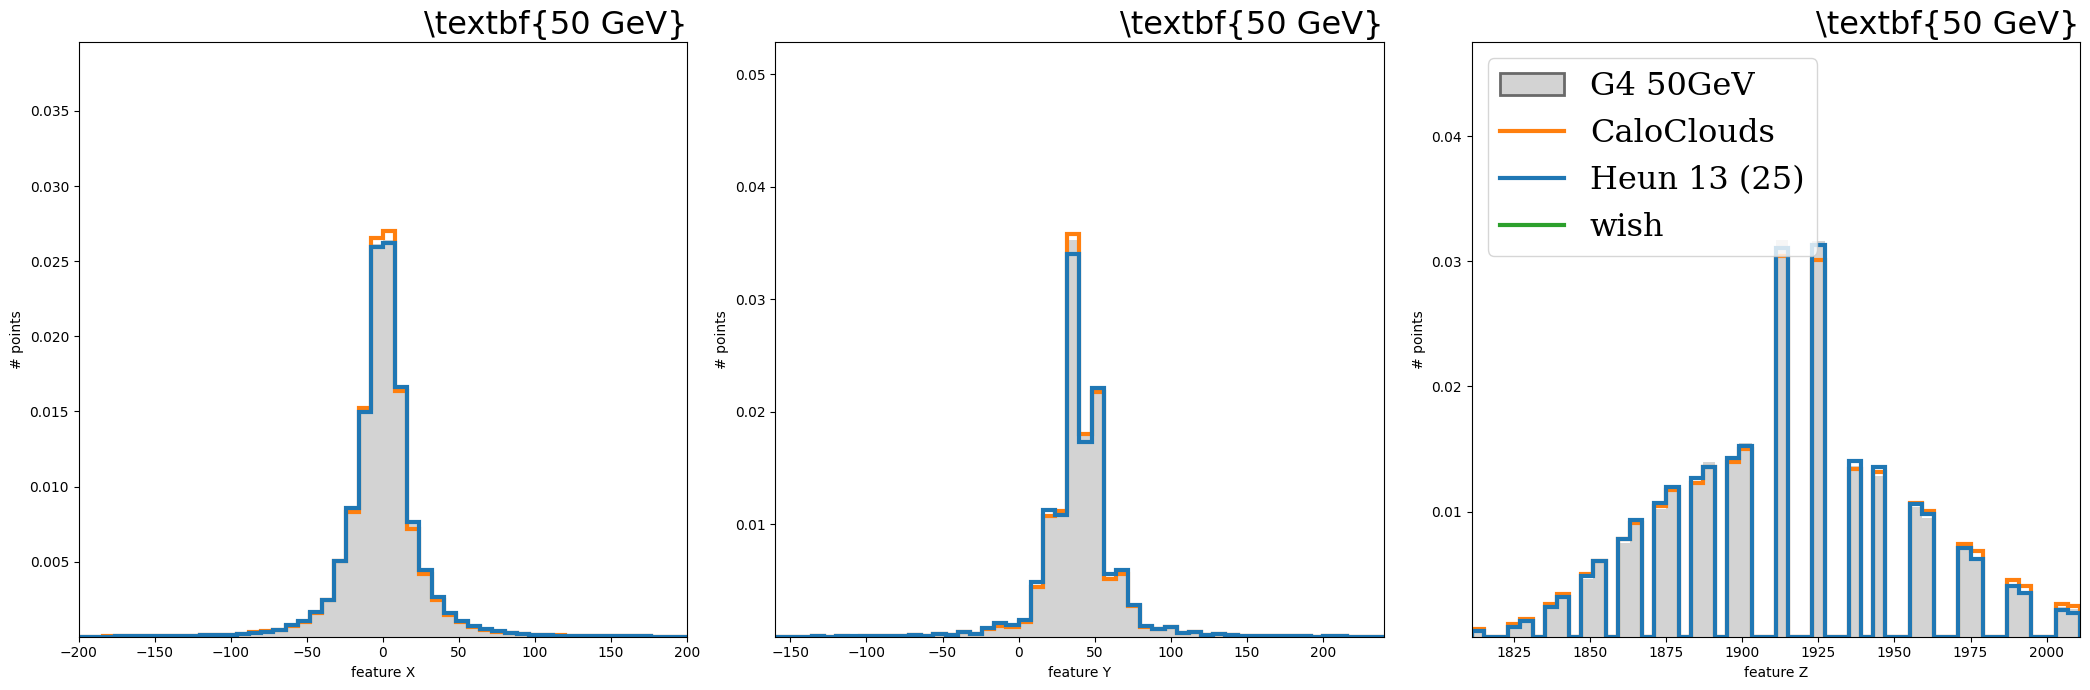

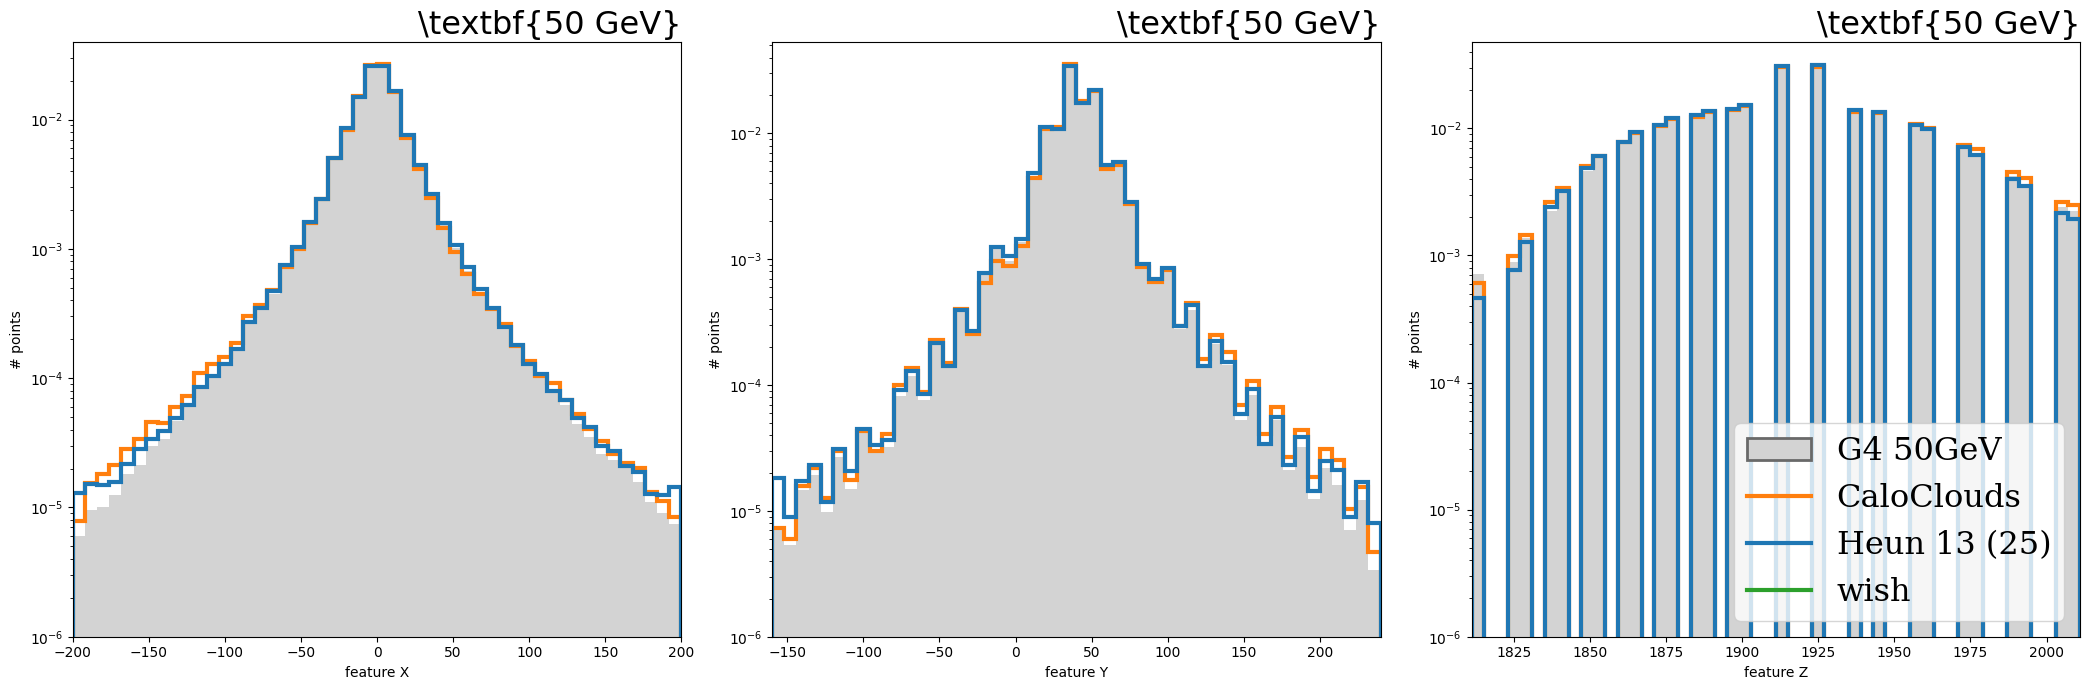

In [61]:
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', "wish"], title=r'\textbf{50 GeV}', density=False)
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', "wish"], title=r'\textbf{50 GeV}', density=True)
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', "wish"], title=r'\textbf{50 GeV}', scale='log', density=True)

In [62]:
events = []

In [67]:
importlib.reload(plotting)
from pointcloud.utils.metadata import Metadata
meta = Metadata(cfg)
real_list, fakes_list = plotting.get_observables_for_plotting(cfg_plt, MAP, meta.half_cell_size_global, events, [events_fake, events_fake_2, events_fake_3])

0it [00:00, ?it/s]


ValueError: need at least one array to concatenate

In [36]:
# pickle
# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/real_list.pickle', 'wb') as f:
#     pickle.dump(real_list, f)
# with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/fakes_list.pickle', 'wb') as f:
#     pickle.dump(fakes_list, f)
# print('pickle saved')

with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/real_list.pickle', 'rb') as f:
    real_list = pickle.load(f)
with open('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/pickle/fakes_list.pickle', 'rb') as f:
    fakes_list = pickle.load(f)
print('pickle loaded')

pickle loaded


In [37]:
importlib.reload(plotting)

plotting.get_plots_from_observables(real_list, fakes_list, labels = [real_label, ddpm_label, edm_label, cm_label], title=title)

  0%|          | 0/30 [00:00<?, ?it/s]100%|██████████| 30/30 [00:00<00:00, 282.77it/s]


ValueError: not enough values to unpack (expected 9, got 8)

In [46]:
importlib.reload(plotting)
metadata = Metadata(config)
X, Y, Z, _ = metadata.load_muon_map()
map_layers, _ = create_map(
    X,
    Y,
    Z,
    metadata.layer_bottom_pos_global,
    metadata.half_cell_size_global,
    metadata.cell_thickness_global,
)events, clouds = get_projections(
    showers,
    map_layers,
    metadata.layer_bottom_pos_global,
    metadata.half_cell_size_global,
    metadata.cell_thickness_global,
    max_num_hits=6000,
    return_cell_point_cloud=True,
)
plotting.get_plots(plt_config, map_layers, metadata.half_cell_size_global, 
                   events, [events_fake, events_fake_2, events_fake_3],
               metadata.global_shower_axis_char,
            labels = [real_label, ddpm_label, edm_label, cm_label],
            title=title,
         )

NameError: name 'events_fake' is not defined